In [4]:
import numpy as np
import matplotlib.pyplot as plt
import stim
import qutip
from stim import PauliString
from scipy.stats import entropy

In [5]:
def random_1qb_paulistring(pvec=None):
    if pvec is None:
        return np.random.choice(['_', 'X', 'Y', 'Z'])
    else:
        # pick with probability pvec   
        return np.random.choice(['_', 'X', 'Y', 'Z'], p=pvec)

def index_to_paulistring(index, num_qubits):
    """
    Converts the index to a Pauli string
    first converts to base-4 then to Pauli string
    """
    base4 = np.base_repr(index, 4)
    base4 = base4.zfill(num_qubits)
    paulistring = ''
    for i in range(num_qubits):
        if base4[i] == '0':
            paulistring += '_'
        elif base4[i] == '1':
            paulistring += 'X'
        elif base4[i] == '2':
            paulistring += 'Y'
        elif base4[i] == '3':
            paulistring += 'Z'
    return paulistring

def paulistring_to_index(paulistring):
    """
    Converts the Pauli string to an index
    first converts to base-4 then to index
    """
    index = 0
    for i in range(len(paulistring)):
        if paulistring[i] == '_':
            index += 0 * 4**(len(paulistring)-i-1)
        elif paulistring[i] == 'X':
            index += 1 * 4**(len(paulistring)-i-1)
        elif paulistring[i] == 'Y':
            index += 2 * 4**(len(paulistring)-i-1)
        elif paulistring[i] == 'Z':
            index += 3 * 4**(len(paulistring)-i-1)
    return index

def random_nqb_paulistring(pvec=None, num_qubits=1):
    if pvec is None:
        ridx = np.random.randint(4**num_qubits)
        return index_to_paulistring(ridx, num_qubits)
    else:
        # pick with probability pvec
        p0 = 1 - np.sum(pvec)
        ridx = np.random.choice(4**num_qubits, p=np.concatenate(([p0], pvec)))
        return index_to_paulistring(ridx, num_qubits)



In [6]:
# entropic functions


def pvec_entropy(pvec):
    p0 = 1 - np.sum(pvec)
    p = np.concatenate(([p0], pvec))
    return -np.sum([p[i]*np.log2(p[i]) for i in range(len(p)) if p[i] > 0])


def estimate_channel_entropy(pvec, num_samples):
    """
    Estimates the entropy of the channel using num_samples samples.
    This function samples a random Pauli 

    pvec: the probability vector of the channel
    num_samples: the number of samples

    returns: the estimated entropy of the channel

    """
    # the number of qubits is log4(len(pvec)+1)
    num_qubits = int(np.log2(len(pvec)+1)/2)

    # sample num_samples random Pauli strings
    samples = [random_nqb_paulistring(pvec, num_qubits) for _ in range(num_samples)]

    # compute the empirical distribution
    empirical_pvec = np.zeros(len(pvec)+1)
    for sample in samples:
        idx = paulistring_to_index(sample)
        empirical_pvec[idx] += 1
    empirical_pvec /= num_samples
    return pvec_entropy(empirical_pvec)

def tensor_pauli_pvecs(p1, p2):
    p1_0 = 1 - np.sum(p1)
    p2_0 = 1 - np.sum(p2)
    p1_ext = np.concatenate(([p1_0], p1))
    p2_ext = np.concatenate(([p2_0], p2))
    p1p2 = np.kron(p1_ext, p2_ext)
    return p1p2[1:] # remove the first element

In [7]:
pvec = tensor_pauli_pvecs([0.51, 0.11, 0.3], [0.01, 0.01, 0.03])
print(pvec)
print(pvec_entropy(pvec))
print(estimate_channel_entropy(pvec, 100))

[0.0008 0.0008 0.0024 0.4845 0.0051 0.0051 0.0153 0.1045 0.0011 0.0011
 0.0033 0.285  0.003  0.003  0.009 ]
2.013259095475293
1.9799827736766327


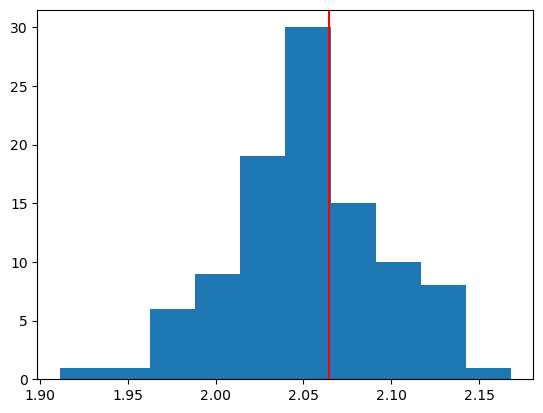

In [8]:
# collect samples of the channel entropy estimate for a given pvec and plot a hist about the true
# entropy of the channel
num_samples = 100
pvec = tensor_pauli_pvecs([0.01, 0.01, 0.3], [0.01, 0.01, 0.3])
samples = [estimate_channel_entropy(pvec, 1000) for _ in range(num_samples)]
plt.hist(samples, bins=10)
plt.axvline(pvec_entropy(pvec), color='r')
plt.show()


In [9]:
pstr = random_nqb_paulistring(num_qubits=10)
idx = paulistring_to_index(pstr)
print(pstr)
print(idx)
print(index_to_paulistring(idx, 10))

YZZ__XZX_Y
770514
YZZ__XZX_Y


In [10]:
ps = PauliString('XX')
ps.to_numpy()

(array([ True,  True]), array([False, False]))

Calculate the effect of a general Pauli error onto its logical component 

In [11]:
class SeparablePauliNoise:
    def __init__(self, p_x, p_y, p_z, num_qubits=1):
        self.p_x = p_x
        self.p_y = p_y
        self.p_z = p_z
        self.num_qubits = num_qubits

    @property 
    def pvec_1q(self):
        px = self.p_x
        py = self.p_y
        pz = self.p_z
        return np.array([1-px-py-pz, px, py, pz])

    def pvec_joint(self):
        # tensor the pvec_1 for each qubit
        pvec = self.pvec_1q
        pvec_joint = np.array([1])
        for i in range(self.num_qubits):
            pvec_joint = np.kron(pvec_joint, pvec)
        return pvec_joint

    def sample_error(self):
        pvec = self.pvec_joint()
        return random_nqb_paulistring(pvec=pvec[1:], num_qubits=self.num_qubits)

In [12]:
class BiasedPauliNoise(SeparablePauliNoise):
    def __init__(self, p, p_z, num_qubits=1):
        pZ = p_z
        pX = (p - pZ) / 2
        pY = pX
        super().__init__(pX, pY, pZ, num_qubits=num_qubits)


In [13]:
class StabilizerCode:
    """
    Represents a stabilizer code

    logicals_generators: the logical operators of the code
    stabilizer_generators: the stabilizer generators of the code
    gauge_generators: the gauge generators of the code


    all operators are represented as stim.PauliString objects
    """
    def __init__(self, logicals_generators, stabilizer_generators, gauge_generators=None):
        self.num_qubits = len(stabilizer_generators[0])
        self.logical_Xs = logicals_generators[0]
        self.logical_Zs = logicals_generators[1]
        self.stabilizer_generators = stabilizer_generators
        if gauge_generators is None:
            gauge_generators = [[], []]
        self.gauge_Xs = gauge_generators[0]
        self.gauge_Zs = gauge_generators[1]

        self.tableau = self._make_stim_tableau()
        self.logical_bits = np.array(range(len(self.logical_Zs)))
        self.stabilizer_bits = np.array(range(len(self.stabilizer_generators))) + len(self.logical_Zs)
        self.gauge_bits = np.array(range(len(self.gauge_Zs))) + len(self.logical_Zs) + len(self.stabilizer_generators)

        # run the checks and raise warnings if the checks fail
        self._check_group_dimensions()
        self._check_operator_support()

        

    def __str__(self):
        return   (f'Code [num_qubits:{self.num_qubits}, num stabs:{len(self.stabilizer_generators)},' +
                 f'num logicals:{len(self.logical_Xs)},{len(self.logical_Zs)},' + 
                 f'num_gauge:{len(self.gauge_Xs)},{len(self.gauge_Zs)}]')
    
    @property
    def logical_autocommutation_matrix(self):
        """
        Returns the commutation matrix of the X and Z logical operators
        """
        commutation_matrix = np.zeros((len(self.logical_Xs), len(self.logical_Zs)))
        for i in range(len(self.logical_Xs)):
            for j in range(len(self.logical_Zs)):
                if self.logical_Xs[i].commutes(self.logical_Zs[j]):
                    commutation_matrix[i, j] = 0
                else:
                    commutation_matrix[i, j] = 1
        return commutation_matrix
    
    def _make_stim_tableau(self):
        # create a list of all the Z logicals, stabilizers, and Z gauges
        zops = self.logical_Zs + self.stabilizer_generators + self.gauge_Zs
        # make the sitme tableau 
        stim_tableau = stim.Tableau.from_stabilizers(zops)
        return stim_tableau
    
    # def parity_check_tensor(self):
    #     """
    #     Returns the parity check matrix of the code

    #     the parity check matrix is a tensor of shape (k, 2, n) where k is the number of stabilizers
    #     and n is the number of qubits
    #     the 1st index of the tensor is the X part and the 2nd index is the Z part

    #     """
    #     pten = np.zeros((len(self.stabilizer_generators), 2, self.num_qubits))
    #     for i in range(len(self.stabilizer_generators)):
    #         bits = self.stabilizer_generators[i].to_numpy()
    #         pten[i, 0, :] = bits[0]
    #         pten[i, 1, :] = bits[1]
    #     return pten

    
    def syndrome(self, error):
        """
        
        """
        return self.tableau(error).to_numpy()[0][self.stabilizer_bits]
        


        # pten = self.parity_check_tensor()
        # error_bits = error.to_numpy()
        # syndrome = np.zeros(len(self.stabilizer_generators))
        # for i in range(len(self.stabilizer_generators)):
        #     syndrome[i] = np.sum(pten[i, 0, :] @ error_bits[1]) % 2
        #     syndrome[i] += np.sum(pten[i, 1, :] @ error_bits[0]) % 2
        # return syndrome
    
    def logical_effect(self, error):
        """
        Returns the effect of the error on the logical operators
        """
        return np.vstack([self.tableau(error).to_numpy()[0][self.logical_bits] , self.tableau(error).to_numpy()[1][self.logical_bits]])
    
    def gauge_effect(self, error):
        """
        Returns the effect of the error on the gauge operators
        """
        return np.vstack([self.tableau(error).to_numpy()[0][self.gauge_bits] , self.tableau(error).to_numpy()[1][self.gauge_bits]])


    def make_joint_distribution(self, pauli_distribution):
        """
        calculate P(Y, Z) under the given Pauli distribution
        """
        pvec = pauli_distribution.pvec_joint()
        joint_distribution = {}
        for i in range(len(pvec)):
            pstr = index_to_paulistring(i, self.num_qubits)
            error = stim.PauliString(pstr)
            syndrome = self.syndrome(error)
            logical_effect = self.logical_effect(error)
            pair = (tuple(syndrome.flatten()), tuple(logical_effect.flatten()))
            if pair in joint_distribution:
                joint_distribution[pair] += pvec[i]
            else:
                joint_distribution[pair] = pvec[i]
        return joint_distribution
    
    # def calculate_logical_marginal_distribution(self, joint_distribution):
    #     """
    #     calculate the marginal distribution of the logical operators
    #     """
    #     logical_distribution = {}
    #     for key, val in joint_distribution.items():
    #         logical_effect = key[1]
    #         if logical_effect in logical_distribution:
    #             logical_distribution[logical_effect] += val
    #         else:
    #             logical_distribution[logical_effect] = val
    #     return logical_distribution
    
    # def calculate_logical_entropy(self, joint_distribution):
    #     logical_marginal = self.calculate_logical_marginal_distribution(joint_distribution)
    #     logical_pvec = np.array(list(logical_marginal.values()))
    #     return entropy(logical_pvec, base=2)
    
    # def calculate_conditional_entropy(self, joint_distribution):
    #     # calculate the entropy of the logical operators conditioned on the syndrome
    #     conditional_entropy = 0
    #     logical_marginal = self.calculate_logical_marginal_distribution(joint_distribution)
    #     for key, val in joint_distribution.items():
    #         syndrome = key[0]
    #         logical_effect = key[1]
    #         p_logical = logical_marginal[logical_effect]
    #         if p_logical > 0:
    #             p_logical_given_syndrome = val / logical_marginal[logical_effect]
    #             if p_logical_given_syndrome > 0:
    #                 conditional_entropy += p_logical_given_syndrome * np.log2(p_logical_given_syndrome)
    #     return -conditional_entropy
        







        # xpart = []
        # zpart = []
        # for idx, l in enumerate(self.logical_Xs):
        #     if l.commutes(error):
        #         xpart.append(0)
        #     else:
        #         xpart.append(1)
        # for idx, l in enumerate(self.logical_Zs):
        #     if l.commutes(error):
        #         zpart.append(0)
        #     else:
        #         zpart.append(1)

        # return xpart, zpart



    def _check_group_dimensions(self):
        if len(self.logical_Xs) != len(self.logical_Zs):
            raise Warning('The number of logical Xs and Zs are not equal')
        if len(self.gauge_Xs) != len(self.gauge_Zs):
            raise Warning('The number of gauge Xs and Zs are not equal')

    def _check_operator_support(self):
        """
        Check that the operators are supported on the correct number of qubits
        """
        for op in self.logical_Xs + self.logical_Zs + self.stabilizer_generators + self.gauge_Xs + self.gauge_Zs:
            if len(op) != self.num_qubits:
                raise Warning(f'The operator {op} is not supported on the correct number of qubits')

    # def _check_logical_commute_stabilizers(self, logical_Xs, logical_Zs ):
    #     """
    #     Check if the logical operators commute with the stabilizers
    #     """
    #     for stabilizer in self.stabilizer_generators:
    #         for logical in logical_Xs + logical_Zs:
    #             if not stabilizer.commutes(logical):
    #                 raise Warning(f'The logical operator {logical} does not commute with the stabilizer {stabilizer}')
    
    # def _check_logical_commute_gauge(self, logical_Xs, logical_Zs ):
    #     """
    #     Check if the logical operators commute with the gauge operators
    #     """
    #     for gauge in self.gauge_Xs + self.gauge_Zs:
    #         for logical in logical_Xs + logical_Zs:
    #             if not gauge.commutes(logical):
    #                 raise Warning(f'The logical operator {logical} does not commute with the gauge {gauge}')
                
    # def _check_logical_commutation(self, logical_Xs, logical_Zs):
    #     """
    #     Check that all Xs commute with Xs, all Zs commute with Zs, and the Xs and Zs anticommute in pairs
    #     """
        
    #     # check that Xs commute with Xs
    #     for i in range(len(logical_Xs)):
    #         for j in range(i+1, len(logical_Xs)):
    #             if not logical_Xs[i].commutes(logical_Xs[j]):
    #                 raise Warning(f'Xs do not commute: {logical_Xs[i]} {logical_Xs[j]}')
                
    #     # check that Zs commute with Zs
    #     for i in range(len(logical_Zs)):
    #         for j in range(i+1, len(logical_Zs)):
    #             if not logical_Zs[i].commutes(logical_Zs[j]):
    #                 raise Warning(f'Zs do not commute: {logical_Zs[i]} {logical_Zs[j]}')

    #     # check that Xs and Zs anticommute in pairs
    #     lcom_mat = self.logical_autocommutation_matrix
    #     # check that each row has exactly one 1
    #     if np.sum(lcom_mat, axis=1).all() != 1:
    #         raise Warning('Xs and Zs do not anticommute in pairs')


        # for i in range(len(logical_Xs)):
        #     for j in range(len(logical_Zs)):
        #         if i == j:
        #             # they should anticommute
        #             if stim.tableau_commutes(logical_Xs[i], logical_Zs[j]):
        #                 return False
        #         else:
        #             # they should commute
        #             if not stim.tableau_commutes(logical_Xs[i], logical_Zs[j]):
        #                 return False


def calculate_logical_marginal_distribution(joint_distribution):
    """
    calculate the marginal distribution of the logical operators
    """
    logical_distribution = {}
    for key, val in joint_distribution.items():
        logical_effect = key[1]
        if logical_effect in logical_distribution:
            logical_distribution[logical_effect] += val
        else:
            logical_distribution[logical_effect] = val
    return logical_distribution

def calculate_syndrome_marginal_distribution(joint_distribution):
    """
    calculate the marginal distribution of the syndrome operators
    """
    syndrome_distribution = {}
    for key, val in joint_distribution.items():
        syndrome = key[0]
        if syndrome in syndrome_distribution:
            syndrome_distribution[syndrome] += val
        else:
            syndrome_distribution[syndrome] = val
    return syndrome_distribution

def calculate_logical_entropy(joint_distribution):
    logical_marginal = calculate_logical_marginal_distribution(joint_distribution)
    logical_pvec = np.array(list(logical_marginal.values()))
    return entropy(logical_pvec, base=2)

def calculate_conditional_entropy(joint_distribution):
    # calculate the entropy of the logical operators conditioned on the syndrome
    conditional_entropy = 0
    joint_entropy = entropy(np.array(list(joint_distribution.values())), base=2)
    syndrome_marginal = calculate_syndrome_marginal_distribution(joint_distribution)
    syndrome_entropy = entropy(np.array(list(syndrome_marginal.values())), base=2)
    return joint_entropy - syndrome_entropy


    # logical_marginal = calculate_logical_marginal_distribution(joint_distribution)
    # for key, val in joint_distribution.items():
    #     syndrome = key[0]
    #     logical_effect = key[1]
    #     p_logical = logical_marginal[logical_effect]
    #     if p_logical > 0:
    #         p_logical_given_syndrome = val / logical_marginal[logical_effect]
    #         if p_logical_given_syndrome > 0:
    #             conditional_entropy += p_logical_given_syndrome * np.log2(p_logical_given_syndrome)
    # return -conditional_entropy


    

In [14]:
# make a 3-qubit repetition code
logicals = [[PauliString('XXX')], [PauliString('ZZZ')]]
stabilizers =  [PauliString('ZZI'), PauliString('IZZ')]

code = StabilizerCode(logicals, stabilizers)

# print('IIX syndrome', code.syndrome(PauliString('IIX')))
# print('IXI syndrome', code.syndrome(PauliString('IXI')))
# print('XII syndrome', code.syndrome(PauliString('XII')))

# print('IIX effect', code.logical_effect(PauliString('IIX')))
# print('IXI effect', code.logical_effect(PauliString('IXI')))
# print('XII effect', code.logical_effect(PauliString('XII')))

In [15]:
noise = SeparablePauliNoise(0.00, 0.1, 0.2, 3)
joint_dist = code.make_joint_distribution(noise)
print(joint_dist)

{((False, False), (False, False)): 0.4769999999999999, ((True, False), (True, False)): 0.053, ((True, True), (False, False)): 0.018000000000000002, ((False, True), (True, False)): 0.0020000000000000005, ((True, True), (False, True)): 0.063, ((False, True), (True, True)): 0.006999999999999999, ((False, False), (False, True)): 0.252, ((True, False), (True, True)): 0.027999999999999997, ((True, True), (True, False)): 0.018000000000000002, ((False, True), (False, False)): 0.0020000000000000005, ((False, False), (True, False)): 0.009000000000000001, ((True, False), (False, False)): 0.0010000000000000002, ((False, False), (True, True)): 0.0, ((True, False), (False, True)): 0.0, ((True, True), (True, True)): 0.063, ((False, True), (False, True)): 0.006999999999999999}


In [16]:
print(calculate_logical_entropy(joint_dist))
print(calculate_conditional_entropy(joint_dist))
print(pvec_entropy(noise.pvec_joint()))
print(pvec_entropy(noise.pvec_joint())/3)

1.651587258637303
1.1488922358637557
3.4703389483411247
1.1567796494470415


In [17]:
def sample_funciton_on_3dgrid(fun, val_range):
    """
    Samples the function fun on a 3d grid of values in val_range

    returns a 3d numpy array of the sampled values
    """
    n = len(val_range)
    samples = np.zeros((n, n, n))
    for i in range(n):
        for j in range(n):
            for k in range(n):
                samples[i, j, k] = fun(val_range[i], val_range[j], val_range[k])
    return samples

def sample_function_on_2dgrid(fun, val_range):
    """
    Samples the function fun on a 2d grid of values in val_range

    returns a 2d numpy array of the sampled values
    """
    n = len(val_range)
    samples = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            samples[i, j] = fun(val_range[i], val_range[i], val_range[j])
    return samples
    

In [ ]:
biased_noise = BiasedPauliNoise(0.1, 0.1, 3)

def sample_entropy_on_bias_grid(code, eta_range, p_range):
    entropy_samples = np.zeros((len(p_range), len(eta_range)))
    for i, p in enumerate(p_range):
        for j, eta in enumerate(eta_range):
            noise = BiasedPauliNoise(p, eta, code.num_qubits)
            joint_dist = code.make_joint_distribution(noise)
            entropy_samples[i, j] = calculate_logical_entropy(joint_dist)
    return entropy_samples


In [103]:
def make_entropy_plot(entropy_samples, eta_range, p_range):
    plt.imshow(entropy_samples, extent=[eta_range[0], eta_range[-1], p_range[0], p_range[-1]], origin='lower', aspect='auto')
    plt.xlabel('eta')
    plt.ylabel('p')
    plt.colorbar()

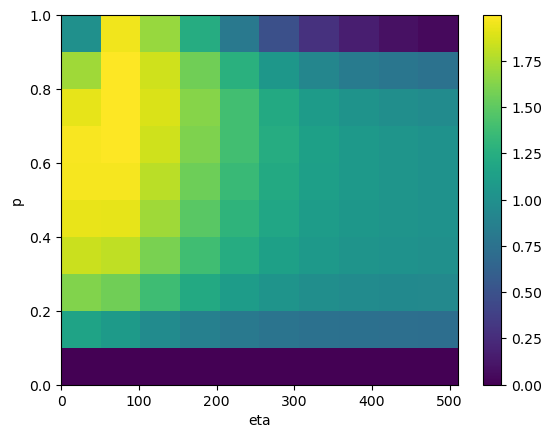

In [118]:
eta_range = np.array([2**i - 1 for i in range(10)])
p_range = np.linspace(0, 1, 10)
entropy_samples = sample_entropy_on_bias_grid(code, eta_range, p_range)
make_entropy_plot(entropy_samples, eta_range, p_range)


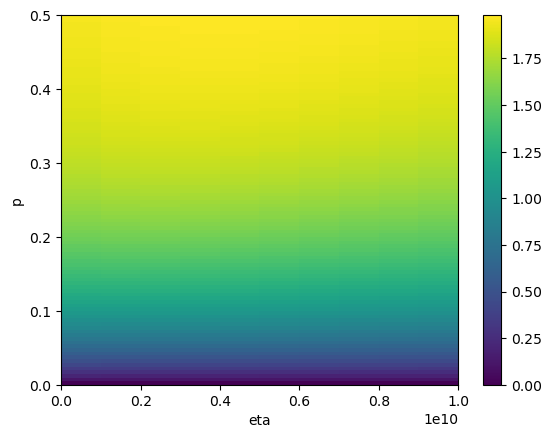

In [112]:
make_entropy_plot(entropy_samples, np.linspace(0, 1e10, 100), np.linspace(0, 0.5, 100))

In [64]:
logical_entropy_fun = lambda px, py, pz: calculate_logical_entropy(code.make_joint_distribution(SeparablePauliNoise(px, py, pz, 3)))
conditional_entropy_fun = lambda px, py, pz: calculate_conditional_entropy(code.make_joint_distribution(SeparablePauliNoise(px, py, pz, 3)))
# logical_entropy_samples = sample_funciton_on_3dgrid(logical_entropy_fun, np.linspace(0, 0.1, 10))

error_rates_range = np.linspace(0, 0.1, 40)
logical_entropy_xz = sample_function_on_2dgrid(logical_entropy_fun, error_rates_range)
conditional_entropy_xz = sample_function_on_2dgrid(conditional_entropy_fun, error_rates_range)

In [ ]:
def make_biased_entropy_estimate(code, p, eta):
    noise = BiasedPauliNoise(p, eta, 3)
    joint_dist = code.make_joint_distribution(noise)
    return calculate_logical_entropy(joint_dist), calculate_conditional_entropy(joint_dist)

In [ ]:
biased_logical_entropy = lambda p, eta: calculate_logical_entropy(code.make_joint_distribution(BiasedPauliNoise(p, eta, 3)))

bias_range = np.linspace(0, 10, 40)
p_range = np.linspace(0, 0.1, 40)


Text(0, 0.5, 'pz')

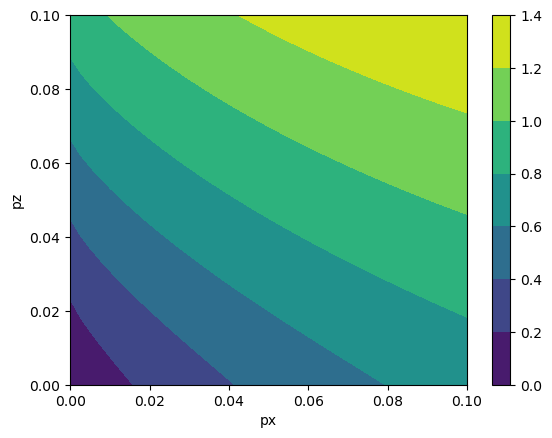

In [65]:
# make a contour plot of the conditional entropy
plt.contourf(error_rates_range, error_rates_range, conditional_entropy_xz)
plt.colorbar()
plt.xlabel('px')
plt.ylabel('pz')

Text(0, 0.5, 'Z error rate')

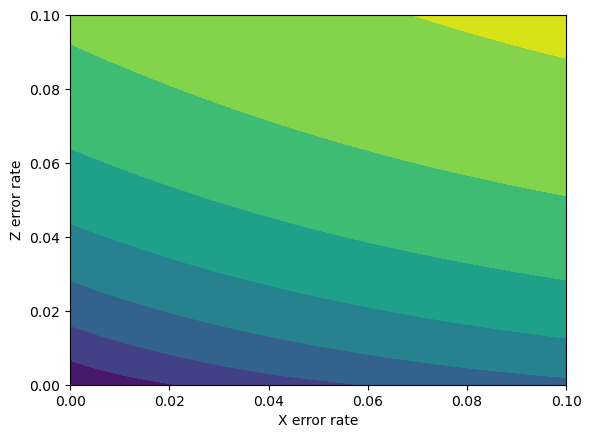

In [49]:
# make a contour plot of the logical 
X, Y = np.meshgrid(error_rates_range, error_rates_range)
plt.contourf(X, Y, logical_entropy_xz)
plt.xlabel('X error rate')
plt.ylabel('Z error rate')

In [31]:
logical_entropy_samples.shape

(10, 10, 10)

In [16]:
import matplotlib.pyplot as plt
import numpy as np


In [25]:
!pip install plotly

In [27]:
import plotly.graph_objects as go

X, Y, Z = np.mgrid[0:0.1:10j, 0:0.1:10j, 0:0.1:10j]
fig = go.Figure(data=go.Volume(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value=logical_entropy_samples.flatten(),
    isomin=0.1,
    isomax=0.8,
    opacity=0.1, # needs to be small to see through all surfaces
    surface_count=17, # needs to be a large number for good volume rendering
))
fig.show()

In [18]:
p = PauliString('IXX')

code.tableau(p).to_numpy()

(array([ True, False,  True]), array([False, False, False]))

In [19]:
code.syndrome(p)

array([False,  True])

In [20]:
code.logical_effect(p)

array([[ True],
       [False]])

In [21]:
code.stim_tableau()

AttributeError: 'StabilizerCode' object has no attribute 'stim_tableau'

In [ ]:
pvec1q = [0.001, 0.00, 0.00]
pvec2q = tensor_pauli_pvecs(pvec1q, pvec1q)
pvec3q = tensor_pauli_pvecs(pvec2q, pvec1q)
print(pvec3q)

[9.98001e-04 0.00000e+00 0.00000e+00 9.98001e-04 9.99000e-07 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 9.98001e-04 9.99000e-07 0.00000e+00
 0.00000e+00 9.99000e-07 1.00000e-09 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00]


In [ ]:
pvec_entropy(pvec1q)

0.011407757737461138

In [ ]:
pvec_entropy(pvec1q)*3

0.034223273212383415

In [ ]:
pvec_entropy(pvec3q)

0.03422327321238341

In [ ]:
def make_codespace_error_distribution(code, pvec):
    """
    Calculates the distribution of errors on the codespace 

    code: the stabilizer code
    pvec: the probability vector of the channel

    returns: the entropy of the code space
    """
    error_effect_dist = {}
    p0 = 1 - np.sum(pvec)
    pvec_ext = np.concatenate(([p0], pvec))
    for idx, rate in enumerate(pvec_ext):
        error = index_to_paulistring(idx, code.num_qubits)
        effect = code.logical_effect(PauliString(error))
        effect_idx = tuple(effect[0] + effect[1])
        if effect_idx in error_effect_dist:
            error_effect_dist[effect_idx] += rate
        else:
            error_effect_dist[effect_idx] = rate
    return error_effect_dist
        

def calc_codespace_entropy(code, pvec):
    """
    Calculates the entropy of the code space

    code: the stabilizer code
    pvec: the probability vector of the channel

    returns: the entropy of the code space
    """
    error_effect_dist = make_codespace_error_distribution(code, pvec)
    entropy = 0
    for key, prob in error_effect_dist.items():
        if prob > 0:
            entropy += - prob * np.log2(prob)
    return entropy

def make_codespace_joint_distribution(code, pvec):
    """
    Calculates the joint distribution of errors on the codespace and syndromes

    code: the stabilizer code
    pvec: the probability vector of the channel

    returns: the entropy of the code space
    """
    error_effect_dist = {}
    p0 = 1 - np.sum(pvec)
    pvec_ext = np.concatenate(([p0], pvec))
    for idx, rate in enumerate(pvec_ext):
        error = index_to_paulistring(idx, code.num_qubits)
        effect = code.logical_effect(PauliString(error))
        syndrome = code.syndrome(PauliString(error))
        effect_key = (tuple(effect[0] + effect[1]), tuple(syndrome))
        if effect_key in error_effect_dist:
            error_effect_dist[effect_key] += rate
        else:
            error_effect_dist[effect_key] = rate
    return error_effect_dist

def calc_codespace_conditional_entropy(code, pvec):
    """
    Calculates the conditional entropy of the code space given the syndrome

    code: the stabilizer code
    pvec: the probability vector of the channel

    returns: the entropy of the code space
    """
    error_effect_dist = make_codespace_joint_distribution(code, pvec)
    entropy = 0
    # first identify the syndromes and calculate their marginals
    syndrome_marginals = {}
    for key, prob in error_effect_dist.items():
        syndrome = key[1]
        if syndrome in syndrome_marginals:
            syndrome_marginals[syndrome] += prob
        else:
            syndrome_marginals[syndrome] = prob

    # calculate the conditional entropy
    for key, prob in error_effect_dist.items():
        logical_class = key[0]
        syndrome = key[1]
        if prob > 0 and syndrome_marginals[syndrome] > 0:
            entropy +=  -prob * np.log2(prob / syndrome_marginals[syndrome])
    return entropy
    


In [ ]:
make_codespace_error_distribution(code, pvec3q)

{(0, 0): 0.9970059959999998, (0, 1): 0.002994004, (1, 1): 0.0, (1, 0): 0.0}

In [ ]:
calc_codespace_conditional_entropy(code, pvec3q)

3.422038565681971e-05

In [ ]:
pvec1q = [0.001, 0.0, 0.0]
pvec2q = tensor_pauli_pvecs(pvec1q, pvec1q)
pvec3q = tensor_pauli_pvecs(pvec2q, pvec1q)

In [ ]:
pvec3q

array([9.98001e-04, 0.00000e+00, 0.00000e+00, 9.98001e-04, 9.99000e-07,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       9.98001e-04, 9.99000e-07, 0.00000e+00, 0.00000e+00, 9.99000e-07,
       1.00000e-09, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00])

In [ ]:
print(pvec_entropy(pvec3q), pvec_entropy(pvec1q))

0.03422327321238341 0.011407757737461138


In [ ]:
calc_codespace_entropy(code, pvec3q)

0.029413817751299767

In [ ]:
calc_codespace_conditional_entropy(code, pvec3q)

3.422038565681971e-05

In [ ]:
x = random_nqb_paulistring(num_qubits=3)
print(PauliString(x))
print(code.syndrome(PauliString(x)))

+XY_
[0. 1.]


In [ ]:
def logical_effect(paulistring, code):
    """
    Computes the logical effect of a Pauli string on a code
    """
    # the logical effect is the stabilizer of the Pauli string
    return code.stabilizer(paulistring)

In [ ]:
print(code)

Code [num_qubits:3, num stabs:2,num logicals:1,1,num_gauge:0,0]


In [ ]:
tab.

SyntaxError: invalid syntax (2749925748.py, line 1)

In [ ]:
ta

NameError: name 'ta' is not defined

In [ ]:
code.syndrome_vector(PauliString('ZZI'))

AttributeError: module 'stim' has no attribute 'tableau_stabilizer_signs'

In [ ]:
tab = code.stabilizer_tableau()

In [ ]:
tab.to_numpy()

(array([[ True, False, False],
        [ True,  True, False],
        [ True,  True,  True]]),
 array([[False, False, False],
        [False, False, False],
        [False, False, False]]),
 array([[False, False, False],
        [False, False, False],
        [False, False, False]]),
 array([[ True,  True, False],
        [False,  True,  True],
        [False, False,  True]]),
 array([False, False, False]),
 array([False, False, False]))

In [ ]:
code.logical_commutation_matrix

array([[1.]])

In [ ]:
c